In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func , text, inspect

In [11]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [12]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(autoload_with=engine, reflect=True)


/var/folders/2_/mwwktp4x4954g982j5z0cljh0000gn/T/ipykernel_71205/324203133.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(autoload_with=engine, reflect=True)


In [13]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


Text(0, 0.5, 'Inches')

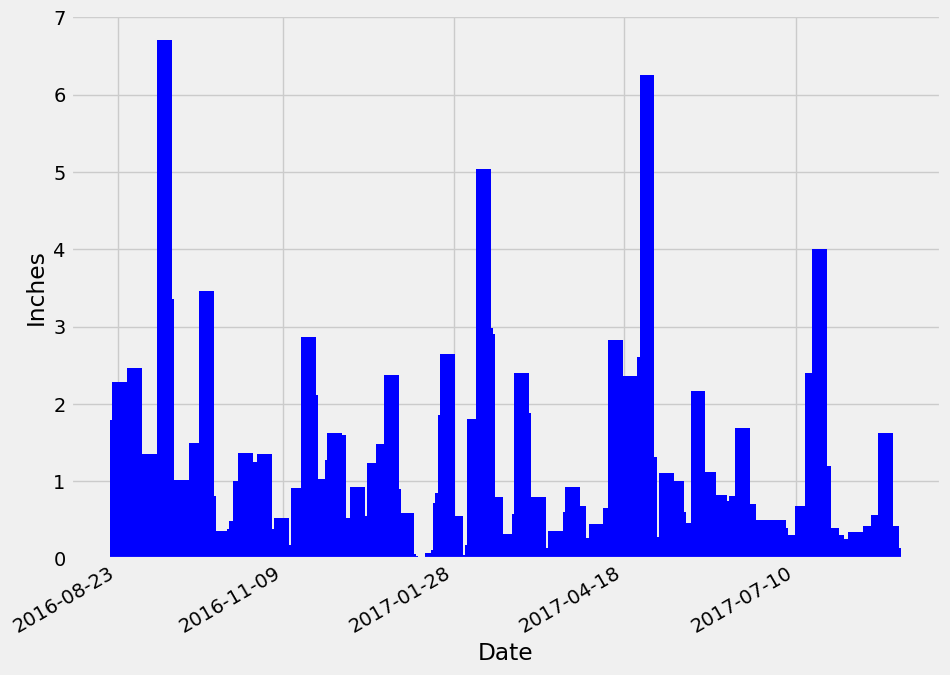

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
current_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Starting from the most recent data point in the database. 
current_date

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_12months = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp,Measurement.tobs).\
    filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_12months, columns= ['id', 'station', 'date', 'prcp', 'tobs'])

# Sort the dataframe by date
precip_df.sort_values(by = 'date')

# Use Pandas Plotting with Matplotlib to plot the data
fig,ax = plt.subplots(figsize = (10, 8))
fig.autofmt_xdate()
x_axis = precip_df['date']
y_values = precip_df['prcp']
plt.bar(x_axis, y_values, color="b", align="center", width=7)
plt.xticks(rotation = 45)
ax.set_xticks( ['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18','2017-07-10'] )
ax.figure.autofmt_xdate()
ax.set_xlabel('Date')
ax.set_ylabel('Inches')

In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df['prcp'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number of stations in the dataset
name_count = session.query(func.count(Station.station)).all()
name_count

[(9,)]

In [20]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(Measurement.station,func.count(Measurement.id )).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id ).desc()).all()
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_summary = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').\
    group_by(Measurement.station).all()
    
station_summary

[(54.0, 85.0, 71.66378066378067)]

Text(0, 0.5, 'Frequency')

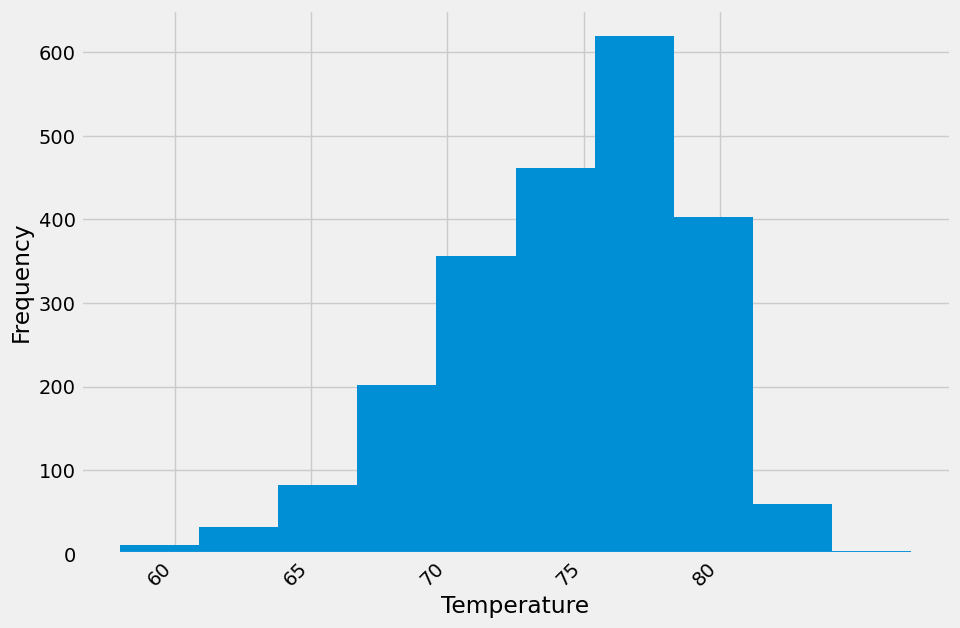

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempt_df = precip_df.loc[precip_df['station'] == 'USC00519281']

tempt_df

fig,ax = plt.subplots(figsize = (10, 8))
fig.autofmt_xdate()
y_values = precip_df['tobs']
plt.hist(y_values)
plt.xticks(rotation = 45)
ax.set_xticks( [60,65,70,75,80] )
ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')

# Close Session

In [23]:
# Close Session
session.close()